In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd 

%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/ColabNotebooks/house_pricing/data')
df_train = pd.read_csv(data_dir / "train.csv")
df_test = pd.read_csv(data_dir / "test.csv")
df_test_original = pd.read_csv(data_dir / "test.csv")

#print(df_train.describe())

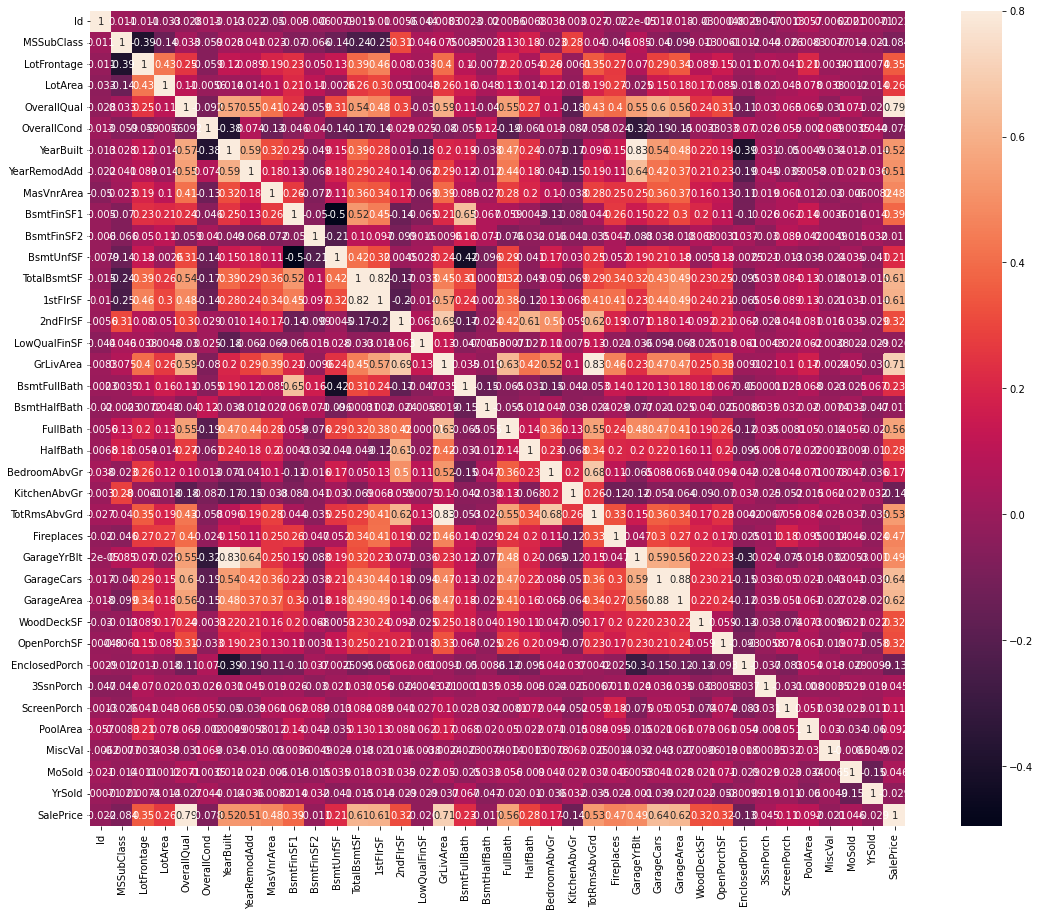

In [ ]:
import seaborn as sns
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

In [ ]:
#remove variables after analysing heatmap, remove ambiguous variables
vars_to_drop = ['GarageArea','TotRmsAbvGrd','GarageYrBlt','Id']

df_train.drop(vars_to_drop, axis=1, inplace=True)
df_test.drop(vars_to_drop, axis=1, inplace=True)

In [ ]:
#Show % of missing values for columns
total = df_train.isnull().sum().sort_values(ascending = False)
percent = (df_train.isnull().sum()/df_train.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data


,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
...,...,...
TotalBsmtSF,0,0.000000
MSZoning,0,0.000000
HeatingQC,0,0.000000
CentralAir,0,0.000000


# Skew variables

In [ ]:
from scipy.stats import skew
from scipy.stats.stats import pearsonr

#Skew variables - only some variables will suffer log transformation
#after dropping na, only the variables with skew value higher than 0.75 will be stored
#and then they will be log-tranformed

numeric_feats = df_train.dtypes[df_train.dtypes != "object"].index

#calculate skewness for all numeric variables
skewed_feats = df_train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

#save only variables with skewness higher than 0.75
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats 

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'],
      dtype='object')

In [ ]:
#log-transform variables (log1p = log(x+ 1)) with skewness > 0.75
df_train[skewed_feats] = np.log1p(df_train[skewed_feats])
vars_to_log = ['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal']
df_test[vars_to_log] = np.log1p(df_test[vars_to_log])


# Data Cleaning

In [ ]:
#Replace NA values
from sklearn.impute import SimpleImputer

cols = df_train.columns
nameNumericVariables = df_train._get_numeric_data().columns

nameCatVariables = list(set(cols) - set(nameNumericVariables))
categorical_features_indices = [df_train.columns.get_loc(c) for c in nameCatVariables if c in df_train]

# Clean numerical features with missing values - replace empty values with mean of column
for columnName in nameNumericVariables:
  meanColumn = df_train[columnName].mean() 
  df_train[columnName].fillna(meanColumn, inplace = True)
  if columnName != 'SalePrice':
    df_test[columnName].fillna(meanColumn, inplace = True)


valueReplaceNA = "empty"
# Clean categorical features with missing values - replace with 'empty' string
for columnName in nameCatVariables: 
  df_train[columnName].fillna(valueReplaceNA, inplace = True)
  df_test[columnName].fillna(valueReplaceNA, inplace = True)

print(nameNumericVariables)
print(nameCatVariables)


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
['GarageFinish', 'BsmtFinType2', 'BldgType', 'MiscFeature', 'GarageType', 'SaleCondition', 'Fence', 'Condition2', 'RoofStyle', 'FireplaceQu', 'ExterCond', 'ExterQual', 'LandContour', 'Functional', 'Electrical', 'BsmtExposure', 'Exterior2nd', 'HouseStyle', 'LandSlope', 'BsmtCond', 'PoolQC', 'SaleType', 'GarageCond', 'LotConfig', 'MasVnrType', 'Alley', 'BsmtQual', 'GarageQual', 'Utilities', 'Heating', 'LotShape', 'RoofMatl', 'PavedDrive', 'Condition1', 'Heat

In [ ]:
#Encode categorical labels
#Encode target labels with value between 0 and n_classes-1.
from sklearn.preprocessing import LabelEncoder

#join train and test sets for encoding
all_data = pd.concat([df_train, df_test])

vars_columns={}
for var in nameCatVariables:
  vars_columns[var] = all_data[var].unique()
  encoder = LabelEncoder()
  encoder.fit(vars_columns[var])

  all_data.loc[:, [var]] = encoder.transform(all_data.loc[:, [var]])

#split train and test sets
df_train = all_data[:df_train.shape[0]]
df_test = all_data[df_train.shape[0]:]

#drop target variable - not needed in test set
df_test.drop('SalePrice', axis=1, inplace=True)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,4.110874,3,4.189655,9.042040,1,2,3,3,0,4,...,0.0,3,4,4,0.000000,2,2008,8,4,12.247699
1,3.044522,3,4.394449,9.169623,1,2,3,3,0,2,...,0.0,3,4,4,0.000000,5,2007,8,4,12.109016
2,4.110874,3,4.234107,9.328212,1,2,0,3,0,4,...,0.0,3,4,4,0.000000,9,2008,8,4,12.317171
3,4.262680,3,4.110874,9.164401,1,2,0,3,0,0,...,0.0,3,4,4,0.000000,2,2006,8,0,11.849405
4,4.110874,3,4.442651,9.565284,1,2,0,3,0,2,...,0.0,3,4,4,0.000000,12,2008,8,4,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,5.081404,4,3.091042,7.568896,1,2,3,3,0,4,...,0.0,3,4,4,0.000000,6,2006,8,4,NaN
1455,5.081404,4,3.091042,7.546974,1,2,3,3,0,4,...,0.0,3,4,4,0.000000,4,2006,8,0,NaN
1456,3.044522,3,5.081404,9.903538,1,2,3,3,0,4,...,0.0,3,4,4,0.000000,9,2006,8,0,NaN
1457,4.454347,3,4.143135,9.253591,1,2,3,3,0,4,...,0.0,3,2,2,6.552508,7,2006,8,4,NaN


In [ ]:
df_test.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 76, dtype: int64

# Training

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

#train test split
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['SalePrice'], axis=1), df_train['SalePrice'],
                                                    test_size=0.30, random_state=45)

In [ ]:
y_train

202     11.626263
417     12.384223
363     11.678448
1428    11.686887
1003    11.827050
          ...    
580     12.111218
163     11.544434
607     12.323860
414     12.337105
971     12.061053
Name: SalePrice, Length: 1022, dtype: float64

In [ ]:
y_test

285     12.011887
872     11.661354
343     12.491255
403     12.460719
1322    12.154785
          ...    
341     11.314487
1114    11.669938
172     12.384223
394     11.599112
1360    12.149508
Name: SalePrice, Length: 438, dtype: float64

Text(0, 0.5, 'rmse')

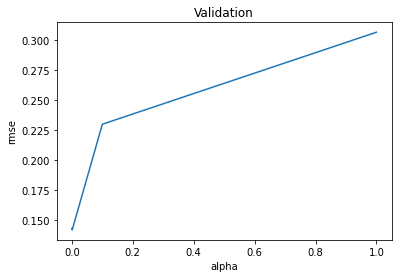

In [ ]:
#Lasso algorithm

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)


model_ridge = Lasso()

#plot the RMSE for different values of alpha
alphas = [1, 0.1, 0.001, 0.0005]
cv_ridge = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")


In [ ]:
model_lasso = LassoCV(alphas = [0.1, 0.001, 0.0005]).fit(X_train, y_train)

print('avg rmse ' + str(rmse_cv(model_lasso).mean()))

avg rmse 0.1414488641621185


In [ ]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 60 variables and eliminated the other 16 variables


In [ ]:
best_features = coef[coef != 0].index
best_features

Index(['MSZoning', 'LotArea', 'LotShape', 'LandContour', 'LotConfig',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'],
      dtype='object')

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

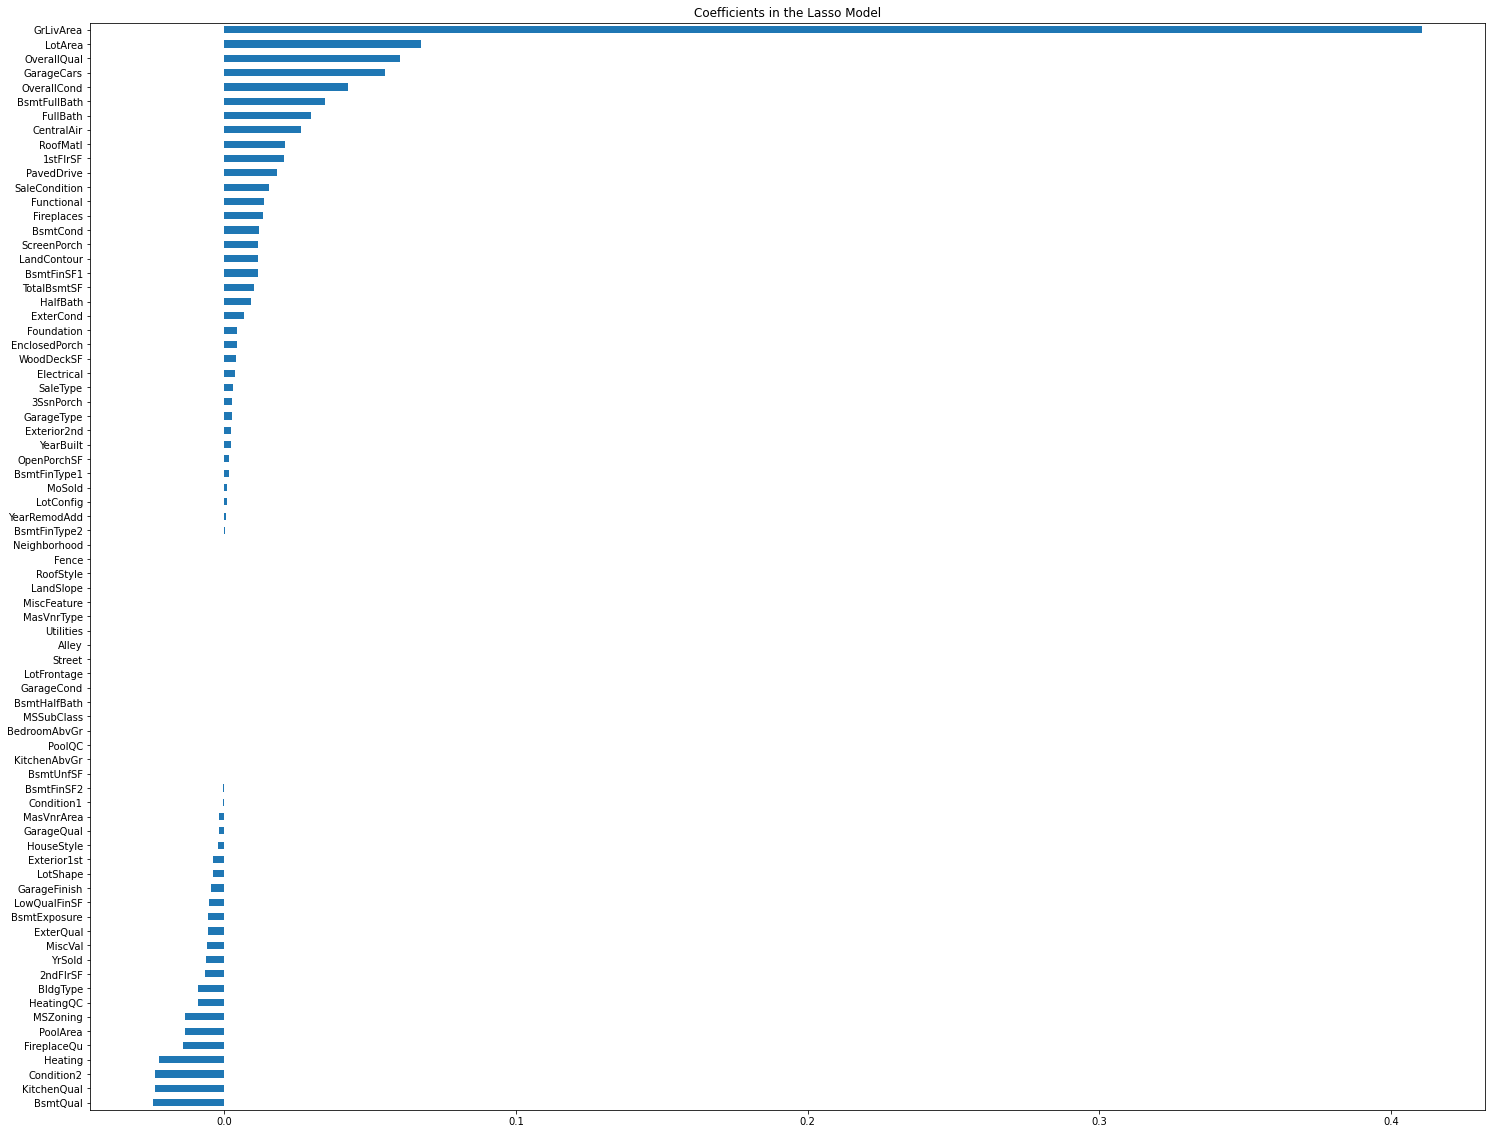

In [ ]:
#Plot coefficients of variables against target variable (house sales price)
#variables with coefficients near 0 do not affect sales price
#if coefficient is negative they negatively affect sales price - reduce the price
#if coefficient is positive they positively affect sales price - increase the price

imp_coef = pd.concat([coef.sort_values()])

plt.rcParams['figure.figsize'] = (25.0, 20.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

#Tensorflow - Training

In [ ]:
import tensorflow as tf

from tensorflow import keras
from keras import layers


In [ ]:
import math
from keras.regularizers import l1


model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1, input_dim = len(best_features), bias_regularizer=l1(0.001)))


model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')


history = model.fit(X_train[best_features], y_train, epochs=25, validation_data=(X_test[best_features], y_test))


print("RMSE")
print(math.sqrt(history.history['val_loss'].pop()))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
32/32 [==============================] - 1s 8ms/step - loss: 21438.1562 - val_loss: 612.1682
Epoch 2/25
32/32 [==============================] - 0s 2ms/step - loss: 648.8090 - val_loss: 64.5513
Epoch 3/25
32/32 [==============================] - 0s 3ms/step - loss: 75.2189 - val_loss: 67.1981
Epoch 4/25
32/32 [==============================] - 0s 2ms/step - loss: 50.8758 - val_loss: 93.4876
Epoch 5/25
32/32 [==============================] - 0s 3ms/step - loss: 58.7617 - val_loss: 42.1939
Epoch 6/25
32/32 [==============================] - 0s 3ms/step - loss: 38.7016 - v

# Testing

In [ ]:
#Predict with Lasso algorithm on y_test (validation set)
y_predictions = model_lasso.predict(X_test)


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

err = mean_squared_error(y_test, y_predictions)
print(math.sqrt(err))

#rmsle = mean_squared_log_error(y_dt_test, y_predictions)
#print(math.sqrt(rmsle))


0.13173972398654063


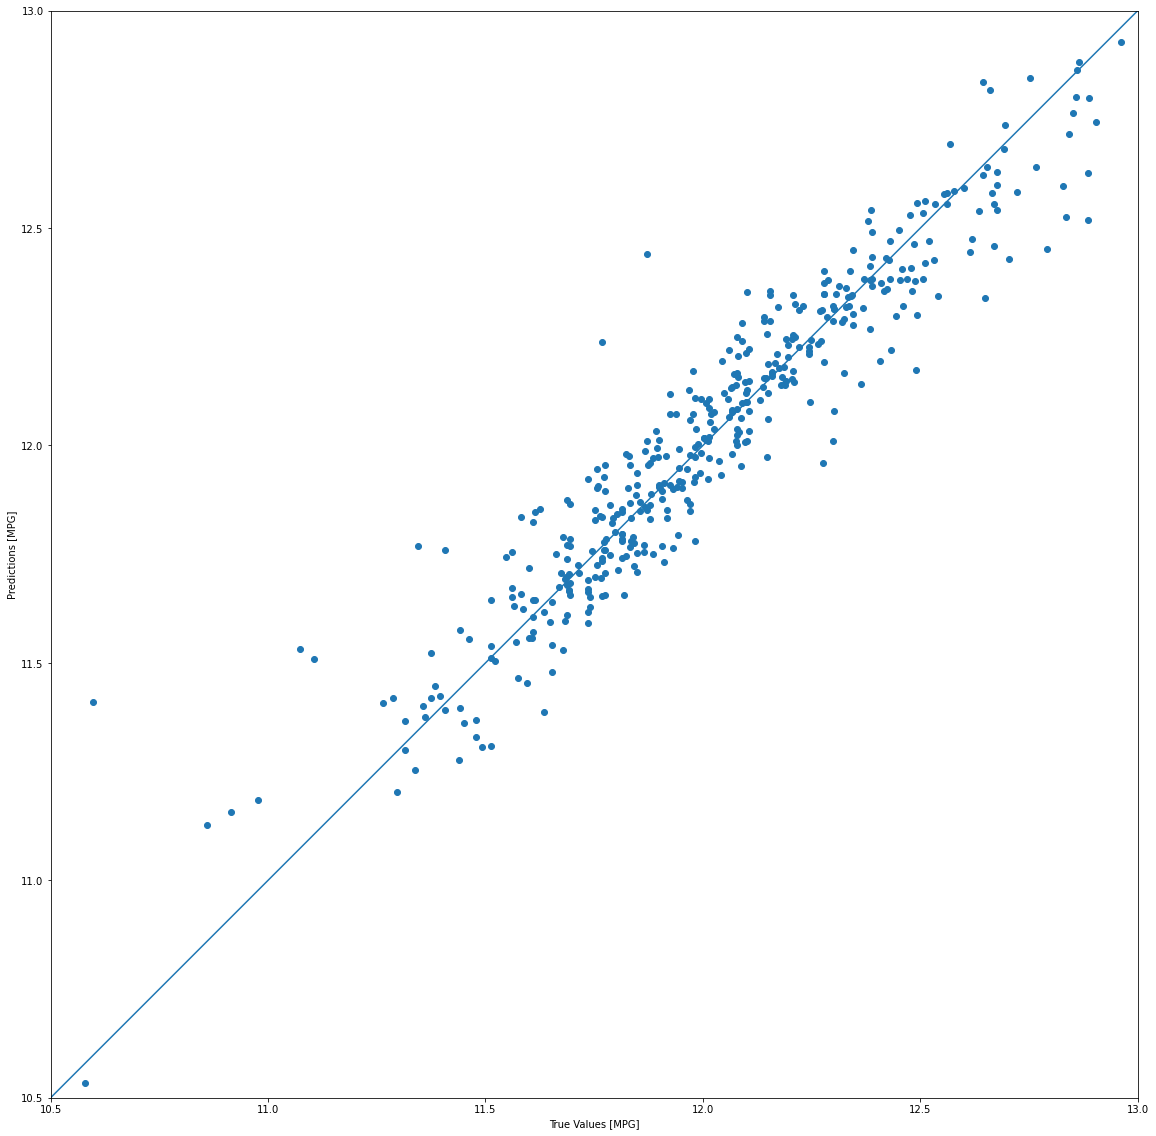

In [ ]:
#Plot predicted values against real values to show differences
a = plt.axes(aspect='equal')
plt.rcParams['figure.figsize'] = (8.0, 10.0)
plt.scatter(y_test, y_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [10.5, 13]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
#predict with test.csv - df_test has the test dataset, where the target values are not known
y_predictions = model_lasso.predict(df_test)


# Export

In [ ]:
predictions_test_dataset = model_lasso.predict(df_test)
predictions_test_dataset = np.expm1(predictions_test_dataset)
df_export = pd.DataFrame({"Id":df_test_original["Id"], "SalePrice":predictions_test_dataset})
df_export.to_csv('result.csv', index=False)